In [1]:
%cd ../../

/mnt/sda/otani/Experiments/eval-detection


In [2]:
from jupyter_bbox_widget import BBoxWidget
import numpy as np
from src.extensions.metrics.ot_cost import get_ot_cost, get_cmap
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

In [24]:
def display_alignment(cmap_fnc, use_dummy=False):
    gt_bboxes = [b for b in bbox_widget.bboxes if b["label"].startswith("GT")]
    fmt_gt_bboxes, gt_bbox_indices = format_bboxes(gt_bboxes, CLASS_LABELS, return_orders=True)
    bboxes = [b for b in bbox_widget.bboxes if not b["label"].startswith("GT")]
    fmt_bboxes, bbox_indices = format_bboxes(bboxes, CLASS_LABELS, return_orders=True)
    otc, log = get_ot_cost(fmt_gt_bboxes, fmt_bboxes, cmap_fnc, return_matrix=True)

    img = plt.imread("data/sample_img/8654786106_fe34dc37fc_z.jpeg")
    plt.imshow(img)
    ax = plt.gca()

    bbox_props = dict(boxstyle="square", ec="0.5", alpha=0.9)

    # draw gt bboxes
    color_map = plt.get_cmap("tab20")
    for i, bi in enumerate(gt_bbox_indices):
        b = gt_bboxes[bi]
        c = color_map(i*2)
        rect = Rectangle((b["x"], b["y"]), b["width"], b["height"], lw=2, ec=c, fc="None")
        ax.add_patch(rect)
        bbox_props["fc"] = c
        ax.text(b["x"], b["y"], b["label"][3:], va="bottom", c="w", fontsize=9, bbox=bbox_props)

    # draw bboxes
    G = log["G"]
    eps = 0.05
    for i, weight in enumerate(G):
        for bi, w in zip(bbox_indices, weight):
            if w>0:
                n_w = w / (G[:, bi].sum() + eps)
                b = bboxes[bi]
                if use_dummy:
                    c = color_map(i*2) if i < len(G)-1 else "tab:gray"
                else:
                    c = color_map(i*2)
                rect = Rectangle((b["x"], b["y"]), b["width"], b["height"], lw=2, ec=c, fc="None", alpha=n_w, ls="--")
                ax.add_patch(rect)
                bbox_props["fc"] = c
                ax.text(b["x"], b["y"], b["label"], va="bottom", c="w", fontsize=9, bbox=bbox_props)
    plt.axis("off")
    
    return plt.gcf()

In [41]:
from IPython.display import display
np.set_printoptions(precision=3)


CLASS_LABELS = ["apple", "banana", "orange", "cup"]
n_class = len(CLASS_LABELS)
img_file = 'data/sample_img/8654786106_fe34dc37fc_z.jpeg'


bbox_widget = BBoxWidget(
    image="../../"+img_file,
    classes= CLASS_LABELS + [" ".join(["GT", l]) for l in CLASS_LABELS],
    colors=["green"] * n_class + ["orange"] * n_class,
    hide_buttons=True
    )

w_conf = widgets.FloatSlider(value=0.5, min=0, max=1., description='Confidence')
bbox_widget.attach(w_conf, name="confidence")

def format_bboxes(bboxes, classes, return_orders=False):
    orders = []
    formatted_bboxes = []
    for label in classes:
        formatted_bboxes.append([])
        for i, bbox in enumerate(bboxes):
            if label in bbox["label"]:
                if bbox["label"].startswith("GT"):
                    conf = 1 
                else:
                    conf = bbox["confidence"]
                formatted_bboxes[-1].append([bbox["x"], bbox["y"], bbox["x"]+bbox["width"], bbox["y"]+bbox["height"], conf])
                orders.append(i)
        formatted_bboxes[-1] = np.asarray(formatted_bboxes[-1], dtype=np.float32).reshape(-1, 5)
    if return_orders:
        return formatted_bboxes, orders
    return formatted_bboxes
    
def evaluate_bboxes():
    gt_bboxes = [b for b in bbox_widget.bboxes if b["label"].startswith("GT")]
    gt_bboxes = format_bboxes(gt_bboxes, CLASS_LABELS)
    bboxes = [b for b in bbox_widget.bboxes if not b["label"].startswith("GT")]
    bboxes = format_bboxes(bboxes, CLASS_LABELS)
    cmap_func = lambda x, y: get_cmap(x, y, alpha=0.5, beta=0.6, use_dummy=True)
    otc, log = get_ot_cost(gt_bboxes, bboxes, cmap_func, return_matrix=True)
    return otc, log

w_out = widgets.Output()

def get_label_count(c_name):
    return len([b for b in bbox_widget.bboxes if b["label"].split()[0] == c_name])

def update_label_conf():
    idx = bbox_widget.selected_index
    cur_label = bbox_widget.bboxes[idx]["label"]

    if cur_label.startswith("GT"):
        return
    
    for c_name in CLASS_LABELS:
        if c_name in cur_label:
            break

    # re-label bboxes of c_name class
    count = 0
    for idx, b in enumerate(bbox_widget.bboxes):
        if b["label"].startswith("GT"):
            continue
        if c_name in b["label"]:
            count += 1
            conf = b["confidence"]
            # new_label = f"{c_name}[{count}] ({conf})"
            new_label = f"{c_name}|{conf}"
            bbox_widget._set_bbox_property(idx, "label", new_label)

def on_bbox_change(change):
    update_label_conf()

    w_out.clear_output(wait=True)
    otc, log = evaluate_bboxes()
    with w_out:
        print(f"{otc:.3f}")
        print("alignment")
        print(log['G'])
        print("const matrix")
        print(log["M"])
        
bbox_widget.observe(on_bbox_change, names=['bboxes'])

w_container = widgets.VBox([
    bbox_widget,
    w_conf,
    w_out,
])
display(w_container)

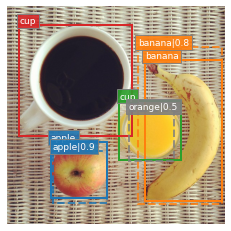

In [48]:
beta = 0.3
cmap_fnc = lambda x, y: get_cmap(x, y, alpha=0.5, beta=beta, use_dummy=True)
f = display_alignment(cmap_fnc, use_dummy=True)
f.savefig(f"outputs/figs/alignment_beta-{beta}.pdf", bbox_inches="tight")